<a href="https://colab.research.google.com/github/morrowbord/Spark/blob/main/mlLib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install koalas pyspark pyarrow -q

     |████████████████████████████████| 390 kB 5.2 MB/s 
     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 198 kB 66.4 MB/s 


Enabling for Conversion to/from Pandas

In [ ]:
from pyspark.sql import SparkSession


spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab_pyspark")\
        .config('spark.ui.port', '4050')\
        .config('spark.executor.memory', '3g')\
        .getOrCreate()
        # .config('spark.sql.execution.arrow.enabled', 'true')\
        # .config('spark."Broadcastsizetable"', '-1')\
        # .config('preferSortHashJoin', 'true')\

# Koalas
[koalas docs](https://koalas.readthedocs.io/en/latest/)

In [ ]:
import databricks.koalas as pd
# import pandas as pd


df = pd.DataFrame({
    'label': [1, 0, 1, 0, 1, 1, 0, 1, 0], 
    'text': ['spark mllib', 'pysaprk code', 'text vector assembler', 'spark', 'transformer', 'estimator', 'we use spark', 'we use python', 'hi, i am sasha']})

df['label2'] = df.label * 2
df

,label,text,label2
0,1,spark mllib,2
1,0,pysaprk code,0
2,1,text vector assembler,2
3,0,spark,0
4,1,transformer,2
5,1,estimator,2
6,0,we use spark,0
7,1,we use python,2
8,0,"hi, i am sasha",0


In [ ]:
type(df)

databricks.koalas.frame.DataFrame

In [ ]:
df.print_schema()

root
 |-- label: long (nullable = false)
 |-- text: string (nullable = false)
 |-- label2: long (nullable = false)



/usr/local/lib/python3.7/dist-packages/databricks/koalas/frame.py:6380: FutureWarning: DataFrame.print_schema is deprecated as of DataFrame.spark.print_schema. Please use the API instead.
  FutureWarning,


In [ ]:
df.spark.repartition(10)

,label,text,label2
4,1,transformer,2
3,0,spark,0
2,1,text vector assembler,2
0,1,spark mllib,2
1,0,pysaprk code,0
7,1,we use python,2
5,1,estimator,2
6,0,we use spark,0
8,0,"hi, i am sasha",0


#MLLib
*   DataFrame
*   Transformer
*   Estimator
*   Pipeline

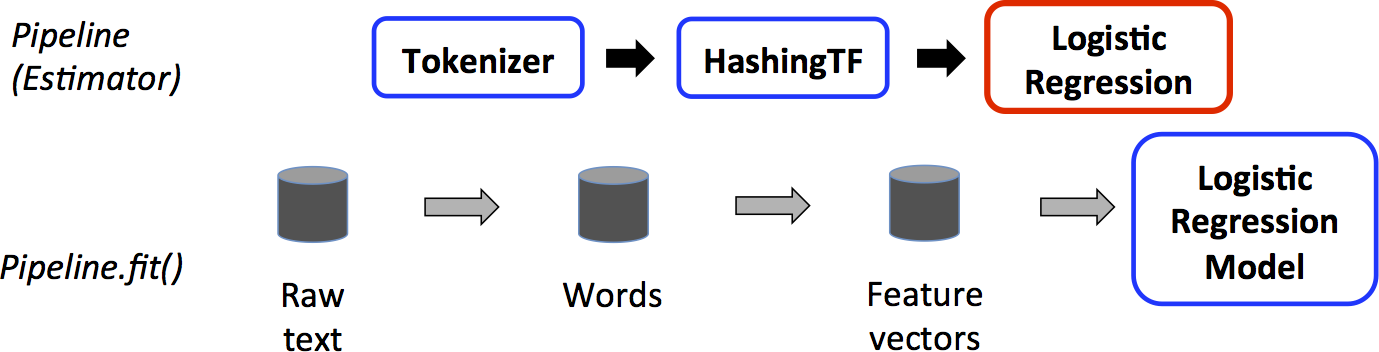



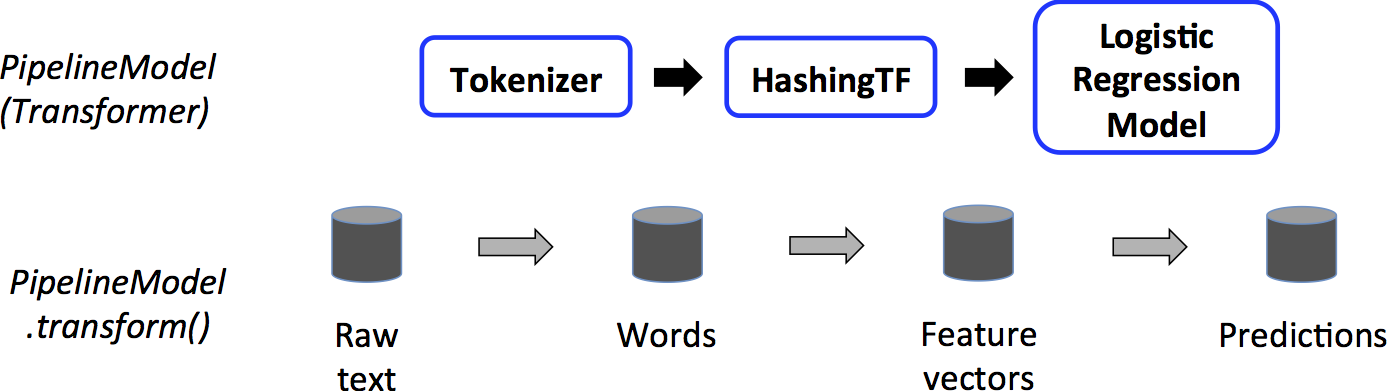

In [ ]:
spark

In [ ]:
from pyspark.ml.feature import HashingTF, Tokenizer, IDF
from pyspark.ml.classification import LogisticRegression

In [ ]:
import pandas as pd
df = pd.DataFrame({
    'label': [1, 0, 1, 0, 1, 1, 0, 1, 0], 
    'text': ['spark mllib', 'pysaprk code', 'text vector assembler', 'spark', 'transformer', 'estimator', 'we use spark', 'we use python', 'hi, i am sasha']})

In [ ]:
df = spark.createDataFrame(df)

In [ ]:
df.show()

+-----+--------------------+
|label|                text|
+-----+--------------------+
|    1|         spark mllib|
|    0|        pysaprk code|
|    1|text vector assem...|
|    0|               spark|
|    1|         transformer|
|    1|           estimator|
|    0|        we use spark|
|    1|       we use python|
|    0|      hi, i am sasha|
+-----+--------------------+



In [ ]:
from pyspark.ml import Pipeline

In [ ]:
tokenizer = Tokenizer(inputCol='text', outputCol='tokens')
tf = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol='tf', numFeatures=20)

In [ ]:
tokenizer.getOutputCol()

'tokens'

In [ ]:
tf.transform(tokenizer.transform(df)).show(truncate=100)

+-----+---------------------+-------------------------+----------------------------------+
|label|                 text|                   tokens|                                tf|
+-----+---------------------+-------------------------+----------------------------------+
|    1|          spark mllib|           [spark, mllib]|             (20,[6,15],[1.0,1.0])|
|    0|         pysaprk code|          [pysaprk, code]|             (20,[0,18],[1.0,1.0])|
|    1|text vector assembler|[text, vector, assembler]|      (20,[9,16,18],[1.0,1.0,1.0])|
|    0|                spark|                  [spark]|                    (20,[6],[1.0])|
|    1|          transformer|            [transformer]|                    (20,[5],[1.0])|
|    1|            estimator|              [estimator]|                    (20,[5],[1.0])|
|    0|         we use spark|         [we, use, spark]|       (20,[6,8,13],[1.0,1.0,1.0])|
|    1|        we use python|        [we, use, python]|       (20,[8,9,13],[1.0,1.0,1.0])|

In [ ]:
tokenizer = Tokenizer(inputCol='text', outputCol='tokens')
tf = HashingTF(inputCol='tokens', outputCol='tf', numFeatures=20)
lr = LogisticRegression(featuresCol='tf', labelCol='label')

In [ ]:
df_tokenized = tokenizer.transform(df)

In [ ]:
df_vectorized = tf.transform(df_tokenized)

In [ ]:
model = lr.fit(df_vectorized)
model.transform(df_vectorized).show()

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|label|                text|              tokens|                  tf|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    1|         spark mllib|      [spark, mllib]|(20,[6,15],[1.0,1...|[-18.431706162396...|[9.89035128939377...|       1.0|
|    0|        pysaprk code|     [pysaprk, code]|(20,[0,18],[1.0,1...|[18.8613958803788...|[0.99999999356423...|       0.0|
|    1|text vector assem...|[text, vector, as...|(20,[9,16,18],[1....|[-18.577420785997...|[8.5492626751036E...|       1.0|
|    0|               spark|             [spark]|      (20,[6],[1.0])|[17.6581425804488...|[0.99999997856289...|       0.0|
|    1|         transformer|       [transformer]|      (20,[5],[1.0])|[-18.418524065316...|[1.00215899589702...|       1.0|
|    1| 

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
tokenizer = Tokenizer(inputCol='text', outputCol='tokens')
tf = HashingTF(inputCol='tokens', outputCol='tf', numFeatures=20)
lr = LogisticRegression(featuresCol='tf', labelCol='label')

pipe = Pipeline(stages=[tokenizer, tf, lr])

In [ ]:
pipe = pipe.fit(df)
pipe.transform(df).show()

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|label|                text|              tokens|                  tf|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    1|         spark mllib|      [spark, mllib]|(20,[6,15],[1.0,1...|[-18.431706162396...|[9.89035128939377...|       1.0|
|    0|        pysaprk code|     [pysaprk, code]|(20,[0,18],[1.0,1...|[18.8613958803788...|[0.99999999356423...|       0.0|
|    1|text vector assem...|[text, vector, as...|(20,[9,16,18],[1....|[-18.577420785997...|[8.5492626751036E...|       1.0|
|    0|               spark|             [spark]|      (20,[6],[1.0])|[17.6581425804488...|[0.99999997856289...|       0.0|
|    1|         transformer|       [transformer]|      (20,[5],[1.0])|[-18.418524065316...|[1.00215899589702...|       1.0|
|    1| 

In [ ]:
type(pipe.fit(df))

pyspark.ml.pipeline.PipelineModel

In [ ]:
pipe.stages[0]

Tokenizer_a752b2d87704